In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#packages
from collections import Counter
from scipy import stats
import numpy as np
import random
import math

#thinkstats modules
import thinkstats2
import thinkplot
import scatter

#thinkstats data
import brfss
import first
import nsfg
import linear

# Chapter 7 Relationships between variables

Starting to look at relationships between variables. Two variables are related if knowing one gives you information about the other.

Using BRFSS weight vs height of respondents:

TODO: for both BRFSS weight vs height following thinkstats. On my own with nsfg birthweights vs mother's age
* (done) Scatterplot
* Binning value to percentile of other value (characterizing relationships)
* Covariance
* Person's correlation
* Spearman's rank correlation


Notes: 
* be wary of types of relationships seen as linear or nonlinear, how best to view visualization of dataset
* which correlation coefficients prove more robust for an analysis
* when considering how to ask why the correlation or any causation assumptions, what testing will be appropriate for types of evidence.

## 7.1 Scatter Plots

Simplest way to check for a relationship between two variables!

Plot BRFSS weight vs height

In [2]:
df = brfss.ReadBrfss(nrows=None)

In [3]:
# function to select random subset from DataFrame

def SampleRows(df, nrows, replace=False):
    """
    Args:
    df = DataFrame
    nrows = number of rows to choose
    replace = boolean indicating whether sampling should be done with replacement (if same row could be chosen more than once)
    """
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

In [4]:
# Extract height (cm) and weight (kg) of respondents in random sampling

sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

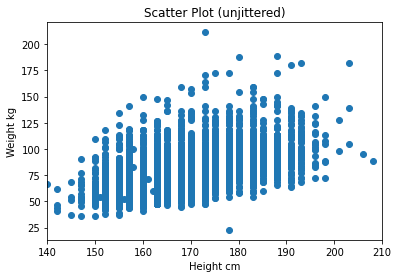

In [5]:
# Simple scatter plot with alpha = 1 for fully saturated

plt.scatter(heights, weights, alpha = 1)

plt.title("Scatter Plot (unjittered)")
plt.xlabel("Height cm")
plt.ylabel("Weight kg")
plt.xlim(140,210)
plt.show()

The plot shows taller people tend to be heavier. But still not the best representation of the data, because the data are packed into columns (from respondents rounding off height).

We can minimize the effect on the scatter plot by jittering the data
* adding random noise to reverse the effect of rounding off
* Jittering reduces the visual effect of rounding and makes the shape of the relationship clearer
* Keep this only for visual purposes and not for analysis

other notes: 
* alpha changes the saturation of data points to not give much visual density to outliers


In [6]:
# version of Jitter using noise with a uniform distribution (normal distribution)

def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0,jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.8 cm, so I'll add random values from -1.4 to 1.4

In [7]:
heights = Jitter(heights, 1.4)
weights = Jitter(weights, 0.5)

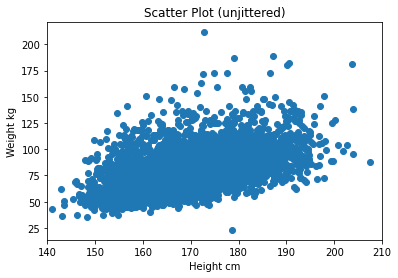

In [8]:
# Plot Scatter Plot with Jitter

plt.scatter(heights, weights, alpha = 1)

plt.title("Scatter Plot (unjittered)")
plt.xlabel("Height cm")
plt.ylabel("Weight kg")
plt.xlim(140,210)
plt.show()

Even with jittering, can cause problems in representing the data. There are many overlapping points, which hides the data in the dense parts of the figure and give disproportionate emphasis to outliers (saturation).

We can solve saturation with adjusting alpha.

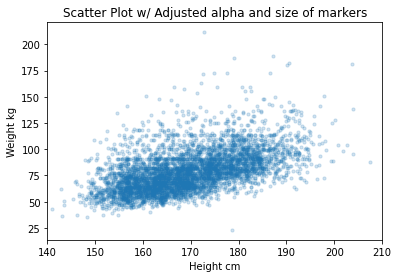

In [9]:
#adjusting alpha and size of markers, s

plt.scatter(heights, weights, alpha = 0.2, s=10)

plt.title("Scatter Plot w/ Adjusted alpha and size of markers")
plt.xlabel("Height cm")
plt.ylabel("Weight kg")
plt.xlim(140,210)
plt.show()

This version helps show the location and shape of the distribution most accurately. There are still some apparent columns and rows where, most likely, people reported height and weight using rounded values. Helps make it apparent. 

Another alternative to scatter plot is `HexBin` plot, which breaks the plane in bins, counts the num of respondents in each bin, and colors each bin in proportion to its count

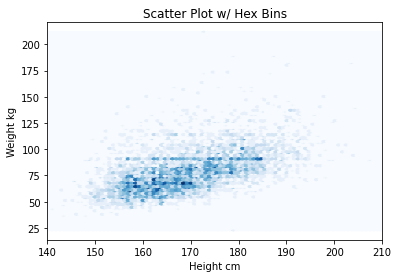

In [10]:
plt.hexbin(heights, weights, cmap='Blues')

plt.title("Scatter Plot w/ Hex Bins")
plt.xlabel("Height cm")
plt.ylabel("Weight kg")
plt.xlim(140,210)
plt.show()

Try making the entire dataset represented well with Scatter and HexBin

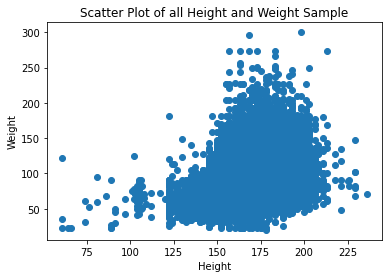

In [11]:
# Scatter plot to show all of the Sample data

plt.scatter(df.htm3, df.wtkg2)

plt.title("Scatter Plot of all Height and Weight Sample")
plt.xlabel("Height")
plt.ylabel("Weight")
plt.show()

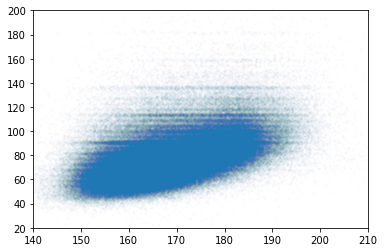

In [12]:
#Excercise to use entire dataset

#more aggressive jittering to blue

ex_heights = Jitter(df.htm3, 2.8)
ex_weights = Jitter(df.wtkg2, 1.0)

plt.scatter(ex_heights, ex_weights, alpha = 0.01, s=2)

plt.xlim(140,210)
plt.ylim(20,200)
plt.show()

## 7.2 Characterizing relationships / Plotting percentiles

Sometimes a better way to get a sense of relationship between variables is to divide dataset into groups using one variable, and then plot percentiles of the other variable.

In [13]:
# drop raw with missing height and weight

clean_df = df.dropna(subset=['htm3', 'wtkg2'])

In [14]:
# divide dataset into groups by height

bins = np.arange(135, 210, 5)
indices = np.digitize(clean_df.htm3, bins)
groups = clean_df.groupby(indices)

print('indices', type(indices))
groups.head()

indices <class 'numpy.ndarray'>


,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0
...,...,...,...,...,...,...
6452,65.0,2,47.727273,195.173030,47.73,122.0
7120,54.0,2,50.000000,94.337255,45.45,137.0
7661,70.0,2,57.272727,99.606163,53.64,122.0
7888,61.0,1,118.181818,548.742780,118.18,221.0


In [15]:
# num of respondents in each group

for i,group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


In [16]:
# Compute CDF of weight within each group

mean_heights = [group.htm3.mean() for i,group in groups]
cdfs = [stats.norm.cdf(group.wtkg2) for i, group in groups]

In [17]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

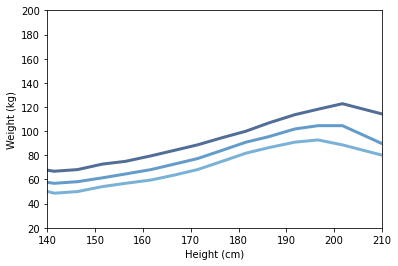

In [18]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

NOTE: hard to compute weights into mapping of values to probability ( InverseCDF(p) ), and then compute Percentiles of (p/100) for every value in the numpy array groupings

## 7.3 Correlation ( a Thought Process)

Correlation is a statistic intended to quantify the strength of the relationship between two variables.

Helps solve challenge in comparing variables with different units, or if same units but from different distributions. 

Common solutions to these problems: 
1. Standard Score, or "Pearson product-moment correlation coefficient": transofrm each values to a number of standard deviations from the mean
2. Rank, or "Spearman rank correlation coefficient": transform each value to it's index in the sort list of values

Standarizing the deviation gives values of $Z$ that are dimensionless(no units) and their distribution has mean 0 and variance 1.
* If $X$, a series of n values, $x_i$, is normally distributed, so is $Z$. If $X$ is skewed or has outliers, so does $Z$; in this case percentile ranks maybe be more robust

## 7.4 Covariance

measure of the tendency of two variables to vary together. 

Cov is the dot product of the deviations, divided by their length.
* Cov computes deviations from the sample means
* `np.cov` returns a covariance matrix

In [19]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

In [20]:
heights, weights = clean_df.htm3, clean_df.wtkg2
Cov(heights, weights)

103.33290857697801

## 7.5 Pearson's Correlation

In [21]:
# code for .MeanVar

#mean
xs = np.asarray(xs)
mean = xs.mean()

#variance
ds = xs - mean
var = np.dot(ds, ds) / len(xs)

NameError: name 'xs' is not defined

In [ ]:
def Corr_np(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = xs.mean(), xs.var()
    meany, vary = ys.mean(), ys.var()

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [ ]:
Corr_np(heights,weights)

In [ ]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

In [ ]:
Corr(heights, weights)

In [ ]:
np.corrcoef(heights, weights)

In [ ]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

In [ ]:
SpearmanCorr(heights, weights)

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [ ]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [ ]:
SpearmanCorr(heights, weights)

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [ ]:
Corr(clean_df.htm3, np.log(clean_df.wtkg2))

**notes**: Speeding through this since there are methods I can use for correlation. But good to know which to use, covariance, Pearson's correlation coefficient, and Spearman Correlation coefficient

# Chapter 8 Estimation

question of how to quantify for sampling error with sampling distributions.

topics covered:
* RMSE (root mean squared error) in sample mean
* Mean Error in sample variance
* Sampling Distribution
    * Standard Error: the RMSE of the sample means
    * Confidence Intervals: an interval that contains percentile rank of values in the sampling distribution (ex 90% CI)
    
Confidence intervals and standard errors quantify variability in the estimate due to random sampling.

Sampling distributions show how much the estimate would vary if experiment is ran over and over.
* If mean of the sampling distribution is pretty close to the hypothetical value of mu, this means the experiment yields the right answer, on average. The given range can suggest how much the hypothetical value of mu is off.

# Chapter 9 Hypothesis Testing

## 9.1 Classical hypothesis testing

**Fundamental Question** : 

Is the effect we see in a sample likely to appear in the larger population?

Does the effect reflect a real difference for a variable/subject or does it appear in the sample by chance?

**Approaches of classical hypothesis testing:** 
* Fisher null hypothesis testing
* Neyman-Pearson decision theory
* Bayesian inference

**Goal**: Answer the question "Given a sample and an apparent effect, what is the possibility of seeing such an effect by chance?"

**Steps**
1. Quantify the size of the apparent effect by choosing a test statistic
2. Define a null hypothesis, 
    * which is a model of the system based on the assumption that the apparent effect is not real
3. Compute a p-value, 
    * which is the probability of seeing the apparent effect if the null hypothesis is true
4. Interpret the result. 
    * If the p-value is low, the effect is said to be statistically significant, which means that it it unlikely to have occured by chance. In that case we infer that the effect is more likely to appear in the larger population. 
    
    
**To test a hypothesis**, we assume, temporarily, that it is not. Based on that assumption, we comput the probability of the apparent effect (p-value). If the p-value is low, we conclude that the null hypothesis is unlikely to be true. 

### Coin Toss
Simple example, suppose we toss a coin 250 times and see 140 heads and 110 tails. Based on this result, we might suspect that the coin is biased; more likely to land on heads. 

To test hypothesis, we compute the probability of seeing such a difference if the coin is actually fair. 

In [ ]:
# Our Sample for hypothesis testing

heads, tails = (140,110)
actual = heads, tails
actual_test_stat = abs(heads - tails)

n = heads + tails

In [ ]:
# num of simulations to run
random.seed(13)

iters = 1000
test_stats = []

for _ in range(iters):

    sample = []
    for _ in range(n):
        sample.append(random.choice('HT'))

    hist = dict()
    for x in sample:
        hist[x] = hist.get(x,0) + 1   
    data = hist['H'], hist['T']

    heads, tails = data
    test_stats.append(abs(heads - tails))
    
#print(len(test_stats))
#print(test_stats)

In [ ]:
#Compute P-Value

count = 0
for x in test_stats:
    if x >= actual_test_stat:
        count +=1
    else: 
        continue
p_value = count / iters
p_value

The p-value turns out to be about 7%.

## 9.3 Permutation Test (difference in means)

### Is mean pregnancy length for first babies slightly longer?
To compute the p-value of an observed difference in means, we can assume that there is no difference between groups and generate simulated results by shuffling the data. 

In [126]:
live, firsts, others = first.MakeFrames()
nsfg_data = firsts.prglngth.values, others.prglngth.values

In [103]:
firsts.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
5,6,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,NaN,8.5625
8,7,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,NaN,7.5625
10,12,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3612.781968,4146.013572,6909.331618,1,31,NaN,7.8125


In [107]:
# test_stat from actual dataset of firsts and others group

group1, group2 = nsfg_data
prglngth_test_stat = abs(group1.mean() - group2.mean())

prglngth_test_stat
group1.mean()

38.60095173351461

In [27]:
# make model

n, m = len(group1), len(group2)
pool = np.hstack((group1,group2))
pool

array([39, 39, 38, ..., 39, 39, 39])

In [28]:
# num of simulations to run
random.seed(14)

iters = 1000
test = []

for _ in range(iters):

    #run model
    np.random.shuffle(pool)
    data = pool[:n], pool[n:]

    #test statistic 
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    test.append(test_stat)

In [29]:
#Compute P-Value

count = 0
for x in test:
    if x >= prglngth_test_stat:
        count +=1
    else: 
        continue
p_value = count / iters
p_value

0.154

Our apparent effect seen is a difference between means in two groups of pregnancy length for first and other babies. We modeled under the assumption that the two groups have the same distribution by randomly shuffling our data (permutation) into the same group sizes. From a p-value of 17%, our actual apparent effect or something bigger likely happens 17% of the time in our null hypothesis, and cannot be considered statistically significant. 

In [30]:
def cdf(sample, title=None):
    x = np.sort(sample)
    y = 1 * np.arange(len(sample)) / (len(sample) - 1)
    plt.plot(x, y)
    plt.title(title)

In [31]:
print(type(plt.title))

<class 'function'>


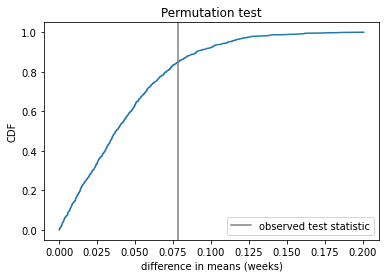

In [45]:
cdf(test, title="Permutation test")

plt.axvline(x=prglngth_test_stat, color='gray',label="observed test statistic")

plt.xlabel("difference in means (weeks)")
plt.ylabel("CDF")
plt.legend()
plt.show()

Plot of the distribution of the test statistic with a gray line indicating the observed effect size. CDF intersects the observed difference at 0.83 (the complement of the p-value 0.17)

Under the null hypothesis, we often see differences bigger than the observed difference.

If the hypothesis under test is that first babies come late, the approprioate test statistic is the raw difference between first babies and others, rather than the absolute value of the difference. In that case, the p-value is smaller, because we are testing a more specific hypothesis.

In [85]:
# num of simulations to run
random.seed(14)

iters = 1000
onesided_test = []

for _ in range(iters):
    
    #run model
    np.random.shuffle(pool)
    data = pool[:n], pool[n:]

    #test statistic 
    group1, group2 = data
    onesided_test_stat = group1.mean() - group2.mean() #raw difference between first and other babies
    onesided_test.append(onesided_test_stat)

In [86]:
#Compute P-Value

count = 0
for x in onesided_test:
    if x >= prglngth_test_stat:
        count +=1
    else: 
        continue
p_value = (count / iters) * 100
p_value

6.9

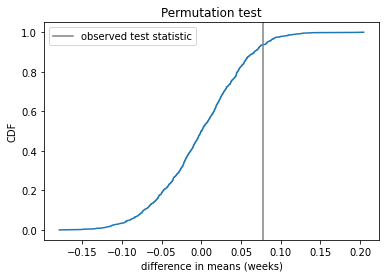

In [52]:
cdf(onesided_test, title="Permutation test")

plt.axvline(x=prglngth_test_stat, color='gray',label="observed test statistic")

plt.xlabel("difference in means (weeks)")
plt.ylabel("CDF")
plt.legend()
plt.show()

But in this example, the result is 6% and is still not statisticall significant.

### Is mean birth weight smaller amongst first borns smaller?

In [128]:
wgt_data = firsts.totalwgt_lb.values, others.totalwgt_lb.values
wgt_data

(array([8.8125, 9.125 , 8.5625, ..., 6.375 , 6.375 , 6.1875]),
 array([7.875 , 7.    , 6.1875, ..., 7.    , 7.5   , 7.5   ]))

In [150]:
# test_stat from actual dataset of firsts and others group

w_group1, w_group2 = wgt_data

#filter out on condition of True where there is a Nan in each group
w_group1_nonan = w_group1[~np.isnan(w_group1)]
w_group2_nonan = w_group2[~np.isnan(w_group2)]

#test stats difference in means
wgt_test_stat = abs(w_group1_nonan.mean() - w_group2_nonan.mean())

wgt_test_stat

0.12476118453549034

In [151]:
# make model

n, m = len(w_group1_nonan), len(w_group2_nonan)
pool = np.hstack((w_group1_nonan,w_group2_nonan))
pool

array([8.8125, 9.125 , 8.5625, ..., 7.    , 7.5   , 7.5   ])

In [156]:
# num of simulations to run
random.seed(14)

iters = 1000
wgt_test = []

for _ in range(iters):

    #run model
    np.random.shuffle(pool)
    data = pool[:n], pool[n:]

    #test statistic 
    group1, group2 = data
    test_stat = abs(group1.mean() - group2.mean())
    wgt_test.append(test_stat)


In [157]:
#Compute P-Value

count = 0.0
for x in wgt_test:
    if x >= wgt_test_stat:
        count +=1.0
    else: 
        continue
p_value = count / iters
p_value

0.0

The same permutation analysis with birth weight shows p-value = 0; after 1000 attempts, the sumulation never yields an effect as big as the observed difference, 0.12 lbs. So we would report $p < 0.001$, and conclude that the difference in birth weight is statistically significant.

## 9.4 Other test statitics

Before our question is whether pregnancy lengths are different for first babies, then it makes sense to test the absolute difference in means. 

One-sided test (count one side of the distribution of differences)
* Test statistic: raw difference in means
    * `test_stat = group1.mean() - group2.mean()`
* p-value = ~9% 
    * still not statistically significant
    
Test for difference in standard deciation
* If we revised and thought if first babies are likely to be late, then instead of taking the abs value of the difference, we would ask for the variance of first babies. Is the variance higher? 
* Test statistic: difference in std
    * `test_stat = group1.std() - group2.std()`
* p-value = ~9% 
    * still not statistically significant 

## 9.5 Testing a correlation

NSFG: correlation between birth weight and mother's age is about 0.07. 

In [8]:
preg = nsfg.ReadFemPreg()
live = preg[preg.outcome == 1]

In [9]:
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [172]:
cleaned = live.dropna(subset=['agepreg','totalwgt_lb'])
print(cleaned.agepreg.corr(cleaned.totalwgt_lb))
print('corr')

0.0688339703541091
corr


Seems older mothers have heavier babies. Could this effect be due to chance?

* Test Statistic: Pearson's Correlation
    * Two-sided test using absolute value of correlation.
* Null Hypothesis: there is no correlation between mother's age and birth weight
    * Model: Shuffle observed values to simulate distributions of age and birth weight as the same and variables are unrelated

In [199]:
# Test Statistic
corr_data = cleaned.agepreg.values, cleaned.totalwgt_lb.values
xs, ys = corr_data
corr_actual_test_stat = abs(cleaned.agepreg.corr(cleaned.totalwgt_lb))

xs

array([33.16, 39.25, 14.33, ..., 17.91, 21.58, 21.58])

In [203]:
#run model
xs, ys = corr_data
xs = np.random.permutation(xs)
print(xs)

[31.5  27.5  31.   ... 20.83 22.58 19.66]


In [205]:
corr_test_data = xs,ys
xs

array([31.5 , 27.5 , 31.  , ..., 20.83, 22.58, 19.66])

In [221]:
# num of simulations to run
random.seed(16)
iters = 50
corr_test = []

for _ in range(iters):
    
    # Run Model
    xs, ys = corr_data
    xs = np.random.permutation(xs)

    #test statistic 
    corr_test_data = xs,ys
    #corr_test_stat = abs(thinkstats2.Corr(xs, ys))
    corr_test_stat = abs(np.corrcoef(xs,ys)) # numpy wouldn't work in this code
    corr_test.append(corr_test_stat)


pearsonr() returns a two-tuple of correlation coefficient and corresponding p-value
* correlation coefficient ranges from -1 to 1
* Null hypothesis is that th etwo variables are uncorrelated. P-Value is a number between 0-1 that represents probability that your data would have arisen if null hypothes

In [233]:
corr_np_test = stats.pearsonr(xs,ys)[1]
corr_np_test

0.30161947705334197

In [219]:
#Compute P-Value

count = 0
for x in corr_test:
    if x >= corr_actual_test_stat:
        count +=1
    else: 
        continue
p_value = (count / iters)
p_value

0.0

The computed p-value is 

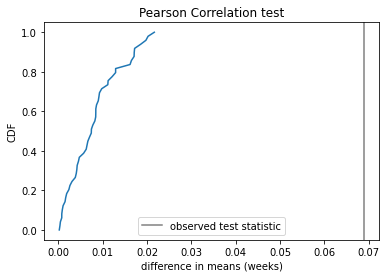

In [220]:
cdf(corr_test, title="Pearson Correlation test")

plt.axvline(x=corr_actual_test_stat, color='gray',label="observed test statistic")

plt.xlabel("difference in means (weeks)")
plt.ylabel("CDF")
plt.legend()
plt.show()

## 9.6 Testing Proportions

Exmaple: Test whether the outcome of a siz-sided die is suspicious

Test- statistic: total abs difference between observed outcomes and expected long-term averages
* compute expected req for each value, the difference between expected and observed freq, and th total abs difference
* sum of abs differences

Null hypothesis: assume that the die is fair
* model: simulate that by drawing random sample from values, then return list of freq

P-Value / Interpret: 


In [5]:
# test statistic
## index corresponds to die value
actual_data = [8, 9, 19, 5, 8, 11]

In [6]:
iters = 10000
die_test = []


for _ in range(iters):
    #run model

    n = sum(actual_data) #need for the size of the model's simulation
    values = [1,2,3,4,5,6] # our die values from each roll

    #creating random values for model (choosing from our values with a size of n. Making sure to choose with replacement)
    rolls = np.random.choice(values, n, replace=True)
    rolls_d = Counter(rolls)
    freqs = list(rolls_d.values())
    
    # compute list of test statistic from simulation
    observed = freqs
    obs_n = sum(observed)
    
    # # our expected from probability of 60 rolls showing 10 freq for each value
    expected = np.ones(6) * 60/6
    
    # sum of abs differences
    die_test_stat = sum(abs(observed - expected))
    
    #append each die_test_stat into our die_test list
    die_test.append(die_test_stat)


In [7]:
# test statistic for the actual dataset

n = sum(actual_data)
expected = np.ones(6) * n/6
actual_test_stat = sum(abs(actual_data - expected))
actual_test_stat

20.0

In [8]:
# compute the p-value from our test statistic (sum of abs differences)

count = 0
for x in die_test:
    if x >= actual_test_stat:
        count +=1
    else: 
        continue
p_value = (count / iters)
p_value

0.1303

P-Value for this data is 0.1, which means that is the die is fair we expect to see the observed total deviation, or more, about 13% of the time. So the observed deviation from the expected values of our apparent effect is not statistically significant.

## 9.7 Chi-squared test

Above we used total deviation. 

More common for testing proportions is to use chi-squared statistic.
* $O_i$ = observed frequencies
* $E_i$ = expected frequencies

[ (observed - expected)** 2 ] / expected
* Squaring the deviations (rather than absolute values) gives more weight to large deviations.
* dividing through by expected standardizes the deviations


In [2]:
# test statistic
## index corresponds to die value
actual_data = [8, 9, 19, 5, 8, 11]

In [3]:
iters = 10000
die_test = []


for _ in range(iters):
    #run model

    n = sum(actual_data) #need for the size of the model's simulation
    values = [1,2,3,4,5,6] # our die values from each roll

    #creating random values for model (choosing from our values with a size of n. Making sure to choose with replacement)
    rolls = np.random.choice(values, n, replace=True)
    rolls_d = Counter(rolls)
    freqs = list(rolls_d.values())
    
    # compute list of test statistic from simulation
    observed = freqs
    obs_n = sum(observed)
    
    # # our expected from probability of 60 rolls showing 10 freq for each value
    expected = np.ones(6) * obs_n/6
    
    # Chi-squared test
    die_test_stat = sum((observed - expected) ** 2 / expected)
    
    #append each die_test_stat into our die_test list
    die_test.append(die_test_stat)

In [4]:
# test statistic for the actual dataset

n = sum(actual_data)
expected = np.ones(6) * n/6
actual_test_stat = sum((observed - expected) ** 2 / expected)
actual_test_stat

9.799999999999999

In [5]:
# compute the p-value from our test statistic (sum of abs differences)

count = 0
for x in die_test:
    if x >= actual_test_stat:
        count +=1
    else: 
        continue
p_value = (count / iters)
p_value

0.0831

Because random, Thinkstats came to 0.0406. So may or may not consider the data statistically significant

Chi-square test of pregnancy length

Observed: apparent differences in the distribution of pregnancy lengths (especially in range 35-43 weeks)

Test whether those differences are statistically significant with Chi-Squared statistic

Null Hypothesis: both samples are drawn from the sample distribution 
* model: distribution by pooling the two samples, and generating simulated data by shuffling the pooled sample and split into parts
* keep range of weeks for values
* expected_probs = probability of each value in the pooled distribution 

p-value / interpret

In [71]:
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [81]:
data

(array([39, 39, 38, ..., 39, 34, 39]), array([39, 39, 39, ..., 39, 39, 39]))

In [94]:
iters = 1000
prglngth_chi_test = []

for _ in range(iters):
# Make Model

    # pooling two samples, and shuffle pooled sample
    firsts, others = data
    n = len(firsts)
    pool = np.hstack((firsts, others))

    # PMF of pool, define week range(35,44)
    pmf = thinkstats2.Pmf(pool)
    values = range(35,44)
    expected_probs = np.array(pmf.Probs(values))

    # Run Model

    # split into two parts
    np.random.shuffle(pool)
    test_data = pool[:n],pool[n:]

    #probability of each value in the pooled distribution

    #Test stats
    t_firsts, t_others = test_data

    #first
    f_hist = thinkstats2.Hist(t_firsts)
    f_observed = np.array(f_hist.Freqs(values))
    f_expected = expected_probs * len(t_firsts)
    f_stat = sum((f_observed - f_expected)**2 / f_expected)

    #other
    o_hist = thinkstats2.Hist(t_others)
    o_observed = np.array(o_hist.Freqs(values))
    o_expected = expected_probs * len(t_others)
    o_stat = sum((o_observed - o_expected)**2 / o_expected)

    stat = f_stat + o_stat
    prglngth_chi_test.append(stat)

In [95]:
#first
af_hist = thinkstats2.Hist(firsts)
af_observed = np.array(f_hist.Freqs(values))
af_expected = expected_probs * len(firsts)
af_stat = sum((af_observed - af_expected)**2 / af_expected)

#other
ao_hist = thinkstats2.Hist(others)
ao_observed = np.array(o_hist.Freqs(values))
ao_expected = expected_probs * len(others)
ao_stat = sum((ao_observed - ao_expected)**2 / ao_expected)

a_stat = af_stat + ao_stat
a_stat

11.661335722757507

In [96]:
# compute the p-value from our test statistic (sum of abs differences)

count = 0
for x in prglngth_chi_test:
    if x >= a_stat:
        count +=1
    else: 
        continue
p_value = (count / iters)
p_value

0.1709

In [ ]:
# Test Statistic

# compute chi-squared statistic for first babies and others, and add them

# ChiSquared: take sequence of prglngth, compute histogram, and compute observed( list of freq to values). Then need expected freq

TODO: still difficult to keep track of all the variables without functions. but managed to run through making a model of a shuffled data set and running the model needed to get a chi-squared test done.

# Chapter 10 Linear Least Squares

10.1 Least squares fit

Correlation coefficients measure strength and sign of a relationship between variables, but not slope.

One way to estimate a slope is a linear least squares fit.
* "linear fit" - line intended to model the relationship between variables
* "least squares" - one that minimizes the mean squared error between line and data

## 10.2 least squares

In [3]:
import first

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])
ages = live.agepreg
weights = live.totalwgt_lb

Following function computes intercept and slope of the least squares fit

In [11]:
def LeastSquares(xs, ys):
    
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    meanx = xs.mean()
    varx = np.dot(xs-meanx,xs-meanx) / len(xs)
    
    meany = ys.mean()
    vary = np.dot(ys-meany,ys-meany) / len(ys)
    
    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    
    slope = cov / varx
    inter = meany - slope * meanx
    
    return inter, slope

The least squares fit to birth weight as function of mother's age

In [14]:
inter, slope = LeastSquares(ages, weights)
inter, slope

(6.830396973311053, 0.017453851471802746)

In [47]:
# Easy to interpret intercept by evaluating it at the mean of the independent variable

inter + slope * 25

7.266743260106122

In [17]:
# Slope easier to interpret if expressed in lbs/decade

slope * 10

0.17453851471802745

Following function evaluates the fitted line at the given xs

In [18]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

In [19]:
fit_xs, fit_ys = FitLine(ages, inter, slope)

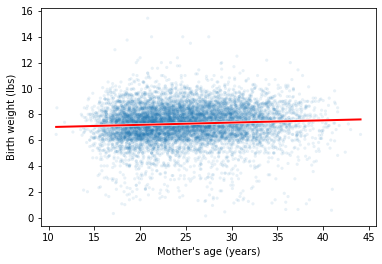

In [45]:
plt.scatter(ages, weights, alpha = 0.1, s=10, edgecolors='none')

plt.plot(fit_xs, fit_ys, color="white", linewidth=3)
plt.plot(fit_xs, fit_ys, color="red", linewidth=2)

plt.xlabel("Mother's age (years)")
plt.ylabel("Birth weight (lbs)")
plt.show()

Scatter plot of birth weight and mother's age with a linear fit

* helpful to present intercept at mean of x. Here, it's mean age = 25 years and mean baby weight for 25 yr old mother is 7.3 lbs. Slope is 0.27 ounces per year, or 0.17 lbs per decade

Looking at the fitted line. It's a good idea to look at a figure like this to assess wether the relationship is linear and whether the fitted line seems like a good model for the relationship

### Least Squares with `np.polyfit()`
* least squares analysis with polynomial functions (linear function is a first degree polynomial)
* args: x and y of data, 1 for degree of polynomial
* function returns slope and intercept of the best fit line

In [91]:
slope, intercept = np.polyfit(ages, weights, 1)
slope, intercept

(0.017453851471802905, 6.8303969733110526)

Plotting with `sns.regplot`
* need to sample from data, since it is difficult to visually change the scatter plot

<AxesSubplot:xlabel='agepreg', ylabel='totalwgt_lb'>

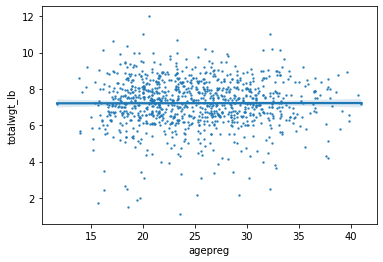

In [101]:
age_sample = ages.sample(1000)
weight_sample = weights.sample(1000)

sns.regplot(x = age_sample, y = weight_sample, scatter_kws={'s':2})

## 10.3 Residuals

When correlation is not perfect (usually the case), resuduals are the vertical deviation from the line when prediction is only approximate. 
* residuals might be due to random factors like measurement error, or nonrandom factors that are unknown

res = ys - Regression line(inter + slope * xs)

In [102]:
def Residuals(xs, ys, inter, slope):
    """
    args: 
    inter and slop are estimated parameters 
    
    """
    xs = np.array(xs)
    ys = np.asarray(ys)
    
    res = ys - (inter + slope * xs)
    return res

In [52]:
# Create column in DataFrame of residuals

live['residual'] = Residuals(ages, weights, inter, slope)

To visualize residuals, split respondents into groups by age, then plot percentiles of residuals vs avg age of each group

In [57]:
# Making groups by age

bins = np.arange(10,48,3)
indices = np.digitize(live.agepreg, bins)
groups = live.groupby(indices)

# Average age for each group

age_means = []
for _,group in groups:
    age_means.append(group.agepreg.mean())
    
age_means = age_means[1:-1]

In [69]:
# compute CDF of the residuals for each group
cdfs = []

for _,group in groups:
    cdfs.append(thinkstats2.Cdf(group.residual))
cdfs = cdfs[1:-1]

In [70]:
def PlotPercentiles(age_means, cdfs):
    thinkplot.PrePlot(3)
    for percent in [75, 50, 25]:
        weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
        label = '%dth' % percent
        thinkplot.Plot(age_means, weight_percentiles, label=label)

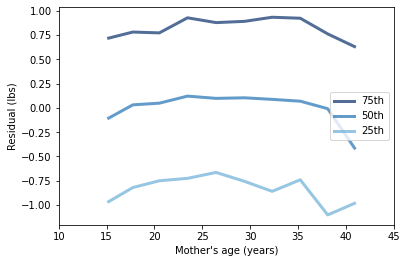

In [71]:
PlotPercentiles(age_means, cdfs)

thinkplot.Config(xlabel="Mother's age (years)",
                 ylabel='Residual (lbs)',
                 xlim=[10, 45])

## 10.4 Estimation

slope and intercept are least squares estimates based on the sample. Vulnerable to chance and sampling bias. 

To assess sampling error, "If we run this experiement again, how much variability do we expect in the estimates?"
* need to run simulated experiments and compute sampling distribution of estimates

To estimate sampling distribution of inter and slope, we'll use resampling 

In [170]:
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb,residual
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125,1.403333
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750,0.359539
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250,2.044489
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000,-0.141599
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875,-0.962826


In [269]:
# resample the given dataframe

iters = 1001
t = []
for _ in range(iters):
    
    indices = np.random.choice(live.index, len(live), replace=True)
    sample = live.loc[indices]
    ages = sample.agepreg
    weights = sample.totalwgt_lb
    estimates = np.polyfit(ages, weights, 1)
    t.append(estimates)
    
# list of estimates for inter and slope
slopes, intercepts = zip(*t)

In [270]:
# finding confidence intervals with stats

stats.norm.interval(alpha=0.90, loc=np.mean(slopes), scale=np.std(slopes))

(0.012728043256297825, 0.02185064010819578)

In [271]:
# take list of estimates and print Mean, Standard Error, and 90% CI

def Summarize(estimates, actual=None):
    mean = np.mean(estimates)
    se = math.sqrt(np.var(estimates))
    confidence_interval = stats.norm.interval(alpha=0.90, loc=np.mean(estimates), scale=np.std(estimates))
    print('mean, se, CI', mean, se, confidence_interval)

In [272]:
Summarize(slopes)

mean, se, CI 0.017289341682246804 0.002773072540444079 (0.012728043256297825, 0.02185064010819578)


In [273]:
Summarize(intercepts)

mean, se, CI 6.8347583859226875 0.0703942300912901 (6.718970181240572, 6.9505465906048025)


### Vizualize Uncertainty of Estimates from Sample

Now, to visualize the estimates, standard errors, and confidence interval. 
* to show uncertainty of the estimate slope and intercept, we generate a fitted line for each resampled estimate and plot them on top of each other

In [201]:
def FitLine(xs, inter, slope):
    fit_xs = np.sort(xs)
    fit_ys = inter + slope * fit_xs
    return fit_xs, fit_ys

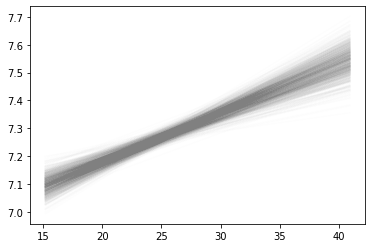

In [204]:
for slope, inter in zip(slopes, inters):
    fxs, fys = FitLine(age_means, inter, slope)
    plt.plot(fxs, fys, color='gray', alpha = 0.01)
    
plt.show()

Or we can make a neater (and more efficient plot) by computing fitted lines and finding percentiles of the fits for each value of the dependent variable.

In [212]:
def PlotConfidenceIntervals(xs, inters, slopes, percent=90, **options):
    fys_seq = []
    for inter, slope in zip(inters, slopes):
        fxs, fys = FitLine(xs, inter, slope)
        fys_seq.append(fys)

    p = (100 - percent) / 2
    percents = p, 100 - p
    low, high = thinkstats2.PercentileRows(fys_seq, percents)
    plt.fill_between(fxs, low, high, **options)

This example shows the confidence interval for the fitted values at each mother's age.

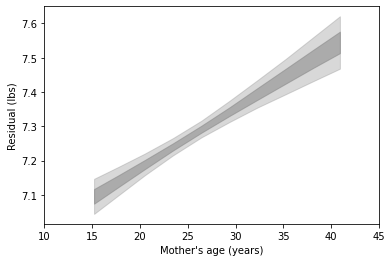

In [215]:
PlotConfidenceIntervals(age_means, inters, slopes, percent=90, 
                        color='gray', alpha=0.3, label='90% CI')
PlotConfidenceIntervals(age_means, inters, slopes, percent=50,
                        color='gray', alpha=0.5, label='50% CI')

plt.xlabel("Mother's age (years)")
plt.ylabel('Residual (lbs)')
plt.xlim([10, 45])
plt.show()

## 10.5 Goodness of fit

How to measure the quality of a linear model, or goodness of fit?
1. Simplest way: standard deviation of residuals
    * If using linear model to make predictions, root mean squared error is the standard deviation of the residuals(prediction errors). 
    * Residuals are a measure of how far from the regression line data points are. The difference between the observed and predicted values
    * Mean squared error (MSE) is the average of all the squared residuals
    * RMSE is the square root of MSE. A measure of how spread out these residuals are. Tells you how concentrated the data is around the line of best fit.
    * $RMSError = \sqrt{1 - r^2} * SD_y$
        * squaring the residuals, finding average of residuals, and taking square root of the result
    * RMSE direct relationship with correlation coefficient. If corrcoef is 1, the RMSE will be 0, because all points lie on the regression line with no errors

Another way: Coefficient of determination, $R^2$
* allows us to measure the strength of the relationship between the response and predictor variables in the model
* just the square of the correlation coefficient $R$, with values in range 0.0 - 1.0

"Good"
* RMSE = means the model generates accurate predictions (small residuals)
* $R^2$ = means that it's the predictor variable doing the actual predictive work, as opposed to response variable simply having low variance and being easy to predict even without the predictor variable

Helpful resources: 
https://medium.com/wwblog/evaluating-regression-models-using-rmse-and-r%C2%B2-42f77400efee

In [239]:
def coef_determination(ys, res):
    #return 1 - np.var(res) / np.var(ys)
    return 1 - Var(res) / Var(ys)

In [241]:
#slope, inter = np.polyfit(ages, weights, 1)

inter, slope = LeastSquares(ages, weights)
res = Residuals(ages, weights, inter, slope)
r2 = coef_determination(weights, res)
r2

0.007879604562173737

We can confirm that $R^2 = \rho^2$:

In [242]:
print('rho', thinkstats2.Corr(ages, weights))
print('R', np.sqrt(r2))    

rho 0.0887671367239801
R 0.08876713672397987


$R^2$ a good indicator of reduction in MSE in a strong correlation.

RMSE a good indicator of predictive power. 

## 10.6 Testing a linear model

The effect of mother's age on birth weight is small, and has little predictive power. Low $R^2$

Is it possible that the apparent relationship is due to chance? How to test the results of a linear fit.

1. test whether the apparent reduction in MSE is due to chance. 
    * Test statistic: $R^2$
    * Null Hypothesis: there is no relationship between the variables. Simulate this model by permutation
    * P-Value: because $R^2 = p^2$, a on-sided test of r2 is equivalent to a two-sided test of p
    
During correlation test between mother's age and birth weight, found p<0.001, and concluded that the apparent relationship between mother's age and birth weight is statistically significant. 
    
2. Test whether the apparent slope is due to chance. 
    * Null Hypothesis: slope is actually zero. 
        * Model the birth weight as random variations around their mean
    
Below: Building Hypothesis Test for this model

In [4]:
live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

ages = live.agepreg
weights = live.totalwgt_lb

weights.head()

0    8.8125
1    7.8750
2    9.1250
3    7.0000
4    6.1875
Name: totalwgt_lb, dtype: float64

In [6]:
#Actual test statistic:
observed_slope, _ = np.polyfit(ages, weights,1)
observed_slope

0.017453851471802905

In [17]:
# make model: Birth weight mean

ybar = np.mean(weights)
res = weights - ybar

In [19]:
# run model

iters = 1000
test_slopes = []

for _ in range(iters):
    
    weights = ybar + np.random.permutation(res)

    #test statistic
    slope,_ = np.polyfit(ages, weights,1)
    test_slopes.append(slope)

In [20]:
count = sum(1 for x in test_slopes if x >= observed_slope)
count/iters

0.0

In [21]:
observed_slope, max(test_slopes)

(0.017453851471802905, 0.009828612257301556)

P-value is less than 0.001, so although the estimated slope is small, it is unlikely due to chance. 

Estimating the p-value by simulating the null hypothesis is strictly correct, but there is a simpler alternative.

Resampling to estimate the sampling distribution of the slope.

In [27]:
xs , freqs = zip(*sorted(Counter(test_slopes).items()))
xs = np.asarray(xs)
ps = np.cumsum(freqs, dtype=float)
ps /= ps[-1]

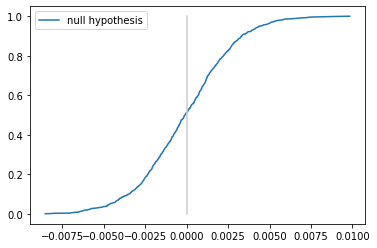

In [37]:
plt.plot(xs, ps, label='null hypothesis')
plt.plot([0,0],[0,1], color='0.8')

plt.legend()
plt.show()